In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import opt_einsum

import sys
sys.path.insert(0, '../fem')
from datasaver import *
sys.path.insert(0, '../ml')
from BSplines import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
data_dir = '../../../trainingdata/VarMiONpaperdata/train'
theta_raw = load_function_list(variable='theta', loaddir=data_dir)
f_raw = load_function_list(variable='f', loaddir=data_dir)
etat_raw = load_function_list(variable='etat', loaddir=data_dir)
etab_raw = load_function_list(variable='etab', loaddir=data_dir)
x_raw = np.load(data_dir + '/x.npy')
u_raw = np.load(data_dir + '/u.npy')

In [5]:
U, Sigma, Vstar = np.linalg.svd(u_raw.T, full_matrices=False)

In [6]:
PODbasis = U.T

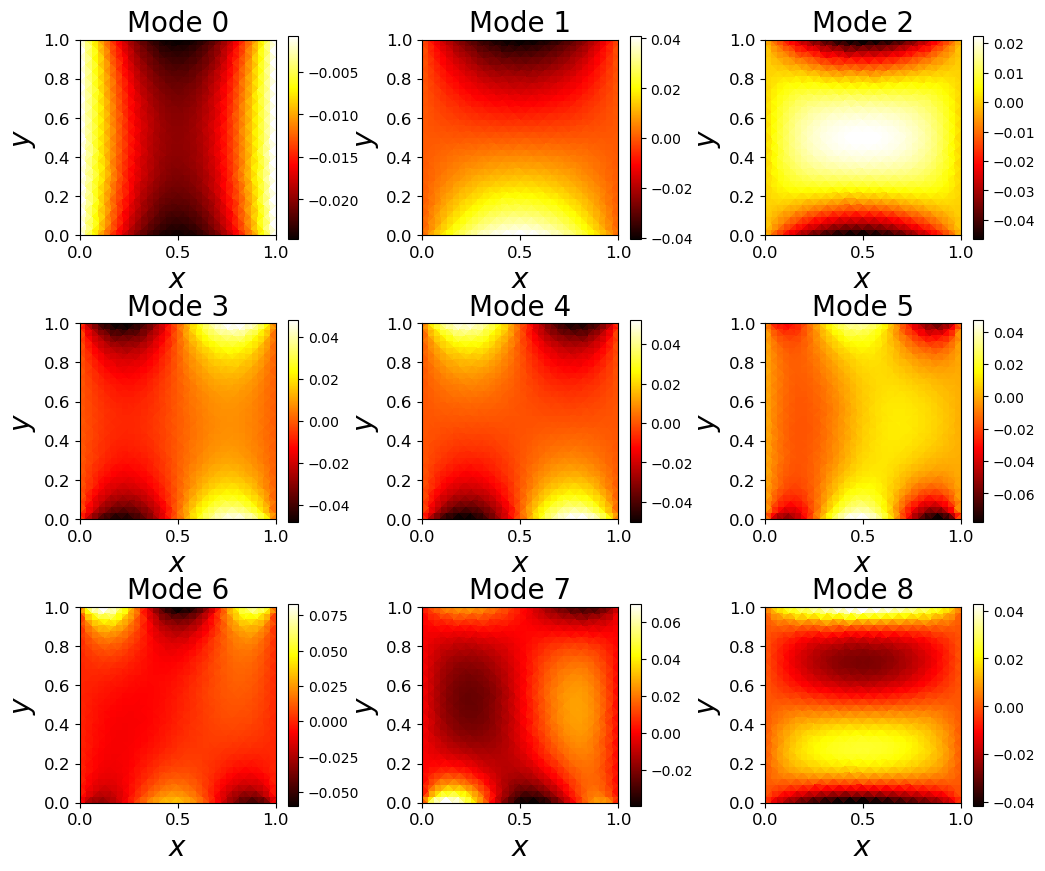

In [10]:
size_ticklabels = 12
size_axeslabels = 20
size_title = 20
box_lw = 10

i=1

fig, axs = plt.subplots(3,3, figsize=(12, 10))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

k=0
for i in range(3):
    for j in range(3):
        ax = axs[i,j]
        plot1 = ax.tripcolor(x_raw[0,:,0], x_raw[0,:,1], PODbasis[k], cmap='hot')
        ax.set_title("Mode "+str(int(k)), fontsize=size_title)
        ax.tick_params(axis='both', labelsize=size_ticklabels)
        ax.ticklabel_format(style='sci', scilimits=[-3,3])
        ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
        ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_aspect('equal')
        fig.colorbar(plot1, ax=ax)
        k+=1

# plt.savefig("POD.svg", bbox_inches='tight', transparent=True)

In [11]:
class BSplineInterpolator2D:
    def __init__(self, x_data, u_data, knots_x, knots_y, polynomial_order):
        self.basis_2d = BSplineBasis2D(knots_x, knots_y, polynomial_order)
        self.coeffs = self.compute_coeffs(x_data, u_data)
        
    def compute_X(self, x_data):
        return self.basis_2d.forward(x_data)
    
    def compute_coeffs(self, x_data, u_data):
        X = self.compute_X(x_data)
        coeffs = np.linalg.lstsq(X, u_data)[0]
        return coeffs
        
    def forward(self, x):
        psi = self.basis_2d.forward(x)
        output = opt_einsum.contract('n,Nn->N', self.coeffs, psi)
        return output
    
    def grad(self, x):
        gradpsi = self.basis_2d.grad(x)
        output = opt_einsum.contract('n,Nni->Ni', self.coeffs, gradpsi)
        return output

In [12]:
knots_x = np.array([0,0,0,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1,1,1,1])
# knots_x = np.array([0,0,0,0,0.2,0.4,0.6,0.8,1,1,1,1])
knots_y = knots_x

In [13]:
interpolator = BSplineInterpolator2D(x_data=x_raw[0], u_data=PODbasis[2], knots_x=knots_x, knots_y=knots_y, polynomial_order=3)

/tmp/ipykernel_669863/1972335931.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeffs = np.linalg.lstsq(X, u_data)[0]


In [14]:
BSI = interpolator.forward(x_raw[0])

In [15]:
BSI.shape

(4096,)

1.4142135621510628


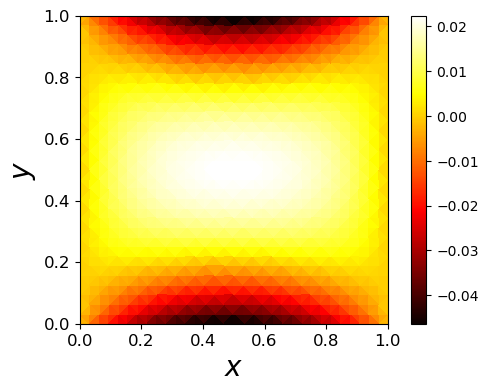

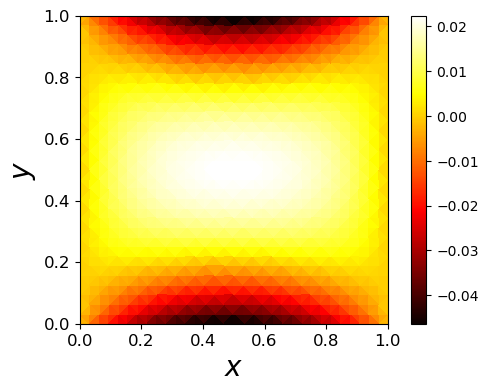

In [16]:
size_ticklabels = 12
size_axeslabels = 20
size_title = 20
box_lw = 10

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plot1 = ax.tripcolor(x_raw[0,:,0], x_raw[0,:,1], PODbasis[2], cmap='hot')
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
fig.colorbar(plot1, ax=ax)

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plot1 = ax.tripcolor(x_raw[0,:,0], x_raw[0,:,1], BSI, cmap='hot')
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
fig.colorbar(plot1, ax=ax)

print(np.linalg.norm(PODbasis[1] - BSI, ord=2)/np.linalg.norm(PODbasis[0], ord=2))


# plt.savefig("POD.svg", bbox_inches='tight', transparent=True)

In [17]:
class BSplineInterpolatedPOD2D:
    def __init__(self, x_data, u_data, h, knots_x, knots_y, polynomial_order):
        self.basis_2d = BSplineBasis2D(knots_x, knots_y, polynomial_order)
        self.PODbasis = self.compute_PODbasis(u_data, h)
        self.PODcoeffs = self.compute_PODcoeffs(x_data, u_data, h, knots_x, knots_y, polynomial_order)
        self.errors = self.compute_projection_errors(x_data)
        
    def compute_PODbasis(self, u_data, h):
        U, self.singularvalues, Vstar = np.linalg.svd(u_data.T, full_matrices=False)
        PODbasis = U.T
        PODbasis_truncated = PODbasis[:h]
        return PODbasis_truncated
    
    def compute_PODcoeffs(self, x_data, u_data, h, knots_x, knots_y, polynomial_order):
        PODbasis = self.compute_PODbasis(u_data, h)
        PODcoeffs = []
        for i in range(len(PODbasis)):
            interpolator = BSplineInterpolator2D(x_data, PODbasis[i], knots_x, knots_y, polynomial_order)
            PODcoeffs.append(interpolator.compute_coeffs(x_data, PODbasis[i]))
        PODcoeffs = np.array(PODcoeffs)
        return PODcoeffs
        
    def forward(self, x):
        psi = self.basis_2d.forward(x)
        output = opt_einsum.contract('nm,Nm->Nn', self.PODcoeffs, psi)
        return output

    def grad(self, x):
        gradpsi = self.basis_2d.grad(x)
        output = opt_einsum.contract('nm,Nmi->Nni', self.PODcoeffs, gradpsi)
        return output
    
    def compute_projection_errors(self, x_data):
        PODbasis_int = self.forward(x_data)
        errors = np.linalg.norm(PODbasis_int.T - self.PODbasis, ord=2, axis=-1)/np.linalg.norm(self.PODbasis, ord=2, axis=-1)
        return errors

In [18]:
PODBasis = BSplineInterpolatedPOD2D(x_data=x_raw[0], u_data=u_raw, h=64, knots_x=knots_x, knots_y=knots_y, polynomial_order=3)

/tmp/ipykernel_669863/1972335931.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeffs = np.linalg.lstsq(X, u_data)[0]


In [19]:
PODBasis.PODcoeffs.shape

(64, 529)

In [20]:
PODbasis_int = PODBasis.forward(x_raw[0])
PODbasis_int.shape

(4096, 64)

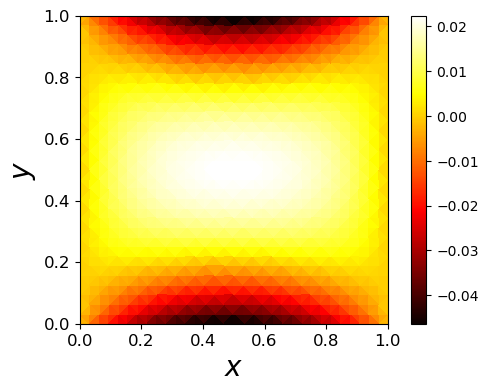

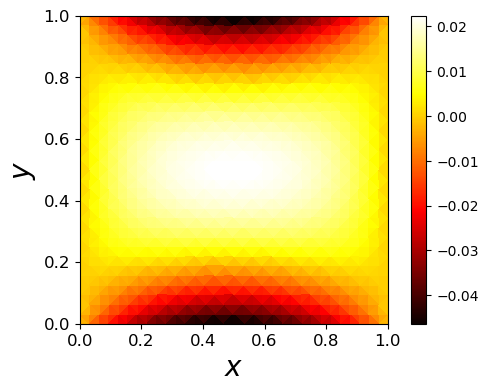

In [21]:
size_ticklabels = 12
size_axeslabels = 20
size_title = 20
box_lw = 10

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plot1 = ax.tripcolor(x_raw[0,:,0], x_raw[0,:,1], PODbasis[2], cmap='hot')
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
fig.colorbar(plot1, ax=ax)

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plot1 = ax.tripcolor(x_raw[0,:,0], x_raw[0,:,1], PODbasis_int[:,2], cmap='hot')
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
fig.colorbar(plot1, ax=ax)

# plt.savefig("POD.svg", bbox_inches='tight', transparent=True)

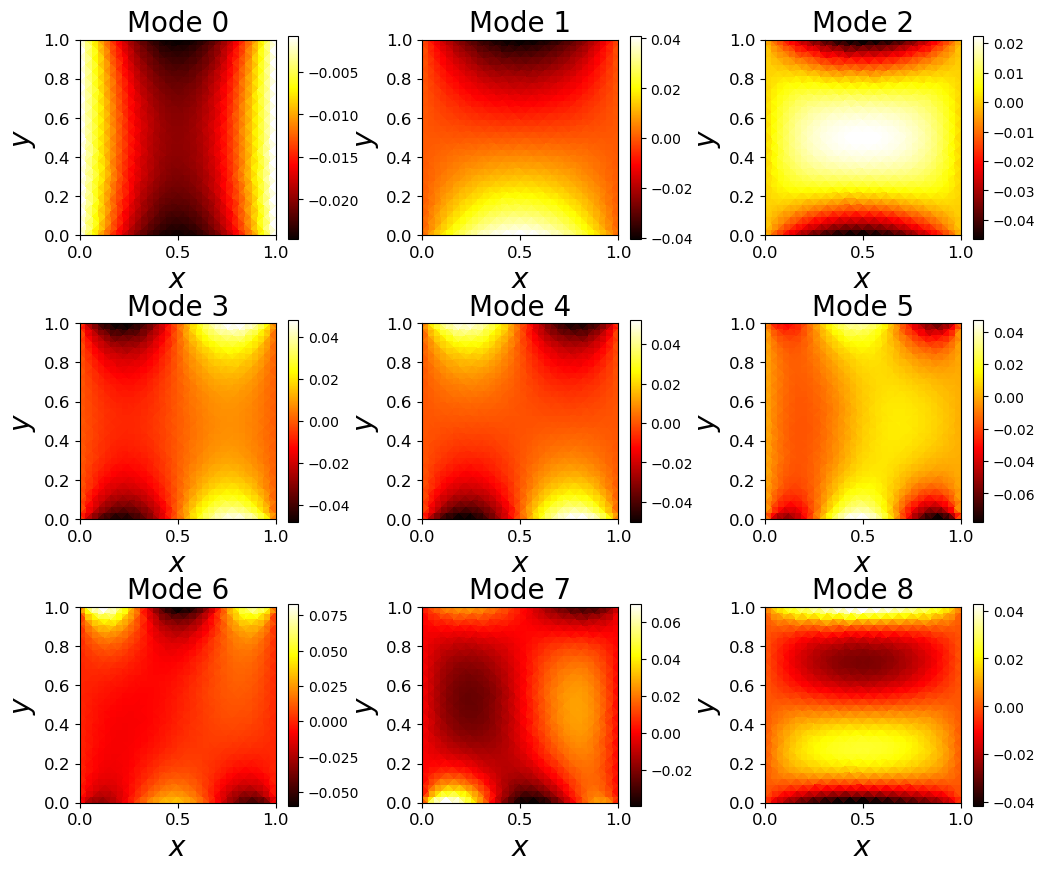

In [22]:
size_ticklabels = 12
size_axeslabels = 20
size_title = 20
box_lw = 10

i=1

fig, axs = plt.subplots(3,3, figsize=(12, 10))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

k=0
for i in range(3):
    for j in range(3):
        ax = axs[i,j]
        plot1 = ax.tripcolor(x_raw[0,:,0], x_raw[0,:,1], PODbasis_int[:,k], cmap='hot')
        ax.set_title("Mode "+str(int(k)), fontsize=size_title)
        ax.tick_params(axis='both', labelsize=size_ticklabels)
        ax.ticklabel_format(style='sci', scilimits=[-3,3])
        ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
        ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_aspect('equal')
        fig.colorbar(plot1, ax=ax)
        k+=1

# plt.savefig("POD_int.svg", bbox_inches='tight', transparent=True)

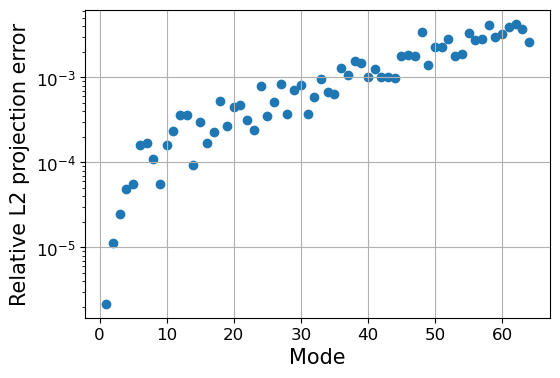

In [24]:
h = np.linspace(1,64,64)

size_ticklabels = 12
size_axeslabels = 15
size_title = 20
box_lw = 10

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

ax.scatter(h,PODBasis.errors)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'Mode', fontsize=size_axeslabels)
ax.set_ylabel(r'Relative L2 projection error', fontsize=size_axeslabels)
ax.set_yscale('log')
ax.grid()

plt.savefig("projectionerrors.svg", bbox_inches='tight', transparent=False)

In [25]:
np.average(PODBasis.errors)

0.0012202706591788767

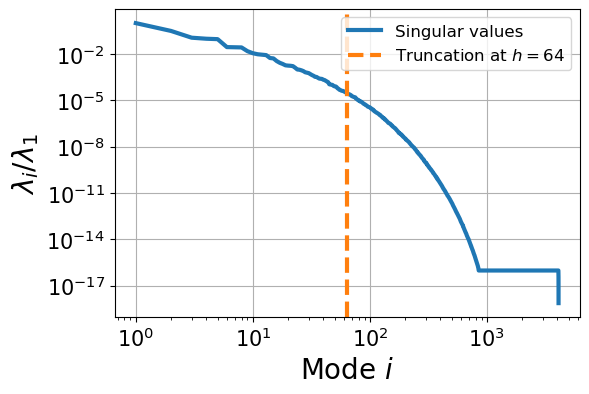

In [248]:
Sigma = PODBasis.singularvalues

size_title = 25
size_ticklabels = 15
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

ax.plot(np.linspace(1,len(Sigma),len(Sigma)),Sigma/Sigma[0], linewidth=3, label='Singular values')
ax.axvline(64, 0, 1, linewidth=3, linestyle='--', label='Truncation at $h=64$', color='C1')
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'Mode $i$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\lambda_i/\lambda_1$', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=12)
# ax.set_ylim(1e-6,1)
# ax.set_xlim(1,1e3)
ax.grid()

plt.savefig("eigenvaluedecay.svg", bbox_inches='tight')#, transparent=True)

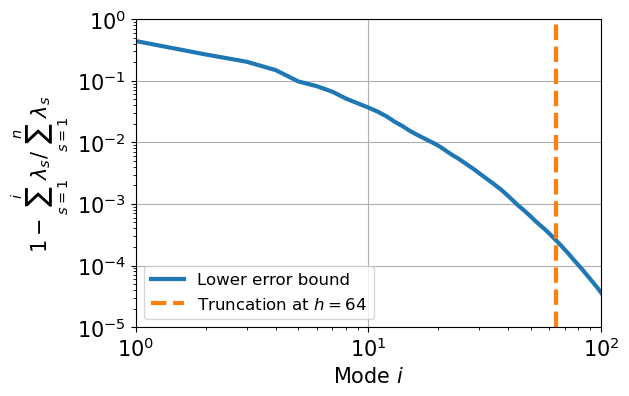

In [252]:
size_title = 25
size_ticklabels = 15
size_axeslabels = 15

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

ax.plot(np.linspace(1,len(Sigma),len(Sigma)),1- np.cumsum(Sigma)/np.sum(Sigma), linewidth=3, label='Lower error bound')
ax.axvline(64, 0, 1, linewidth=3, linestyle='--', label='Truncation at $h=64$', color='C1')
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'Mode $i$', fontsize=size_axeslabels)
ax.set_ylabel(r'$1- \sum_{s=1}^i\lambda_s/\sum_{s=1}^n\lambda_s$', fontsize=size_axeslabels)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-5,1)
ax.set_xlim(1,1e2)
ax.legend(fontsize=12)
ax.grid()

plt.savefig("errorbound.svg", bbox_inches='tight')#, transparent=True)